# DMBook Project
by Andre Rios

In [1]:
#Libraries
import json
import requests
import csv
from csv import reader
import nltk
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.corpus import stopwords
from collections import Counter
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from functools import reduce
import string
import scipy
from scipy.io import arff
import sys
import re
import pickle
import collections
import seaborn as sns
import sklearn.metrics
reload(sys)
sys.setdefaultencoding("utf-8")

In [2]:
#Read dataset
df = pd.read_json('export-2017-12-21.json')

In [3]:
#### Exploratory Analysis
#Preview
df.head(n=10)

,book_name,bookt_type,content,id,tags,user_id
0,DM Log,log,Edita from Sanovita called in sick for thie ev...,11786,[staffingIssue],112
1,DM Log,log,182 and 629 are VIP's.,12114,[VIP],112
2,DM Log,log,had to move Mr Pires room 175 to 272 he is wit...,13255,[roomMove],112
3,Nights,log,Guest in room 539 no wake up call 2 nd time in...,13503,"[guestIncident, wakeUpCall]",112
4,Maintenance,log,!Urgent! - Please replace outside balcony door...,13699,[maintenance],112
5,10.30am Briefing Notes,log,"Failte Inspection tomorrow, all staff in full ...",13826,[internal],112
6,10.30am Briefing Notes,log,"Please ensure all areas are immaculate, if you...",13827,[internal],112
7,DM Log,log,"Till in Pegasus still broken, so we swapped it...",14569,[maintenance],142
8,Reception Handover,log,2 boxes of 10% cards are being collected by Lo...,17587,[forCollection],144
9,Concierge,log,#lucas #Christensen #Minocha #Forbes #Stekelen...,17810,[guestRequest],188


In [4]:
#766 records (rows) and 6 columns
df.shape

(766, 6)

In [5]:
#Converting the tag column to a list and then this is flattened. 
ltag=df.tags.tolist()
ltag1 = [item for sublist in ltag for item in sublist]

In [6]:
df.isnull().values.any()

False

In [7]:
#Frequency tags
df1 = DataFrame({'tags': ltag1})
count1= df1['tags'].value_counts()

#Frequency book_name
df2 = DataFrame({'name':df.book_name})
count2= df2['name'].value_counts()

In [8]:
count1.head()

guestIncident    211
maintenance      191
internal          72
roomMove          67
staffingIssue     55
Name: tags, dtype: int64

In [9]:
count2.head()

Maintenance           119
DM Log                113
Reception Handover     44
Duty Manager           40
Reception              35
Name: name, dtype: int64

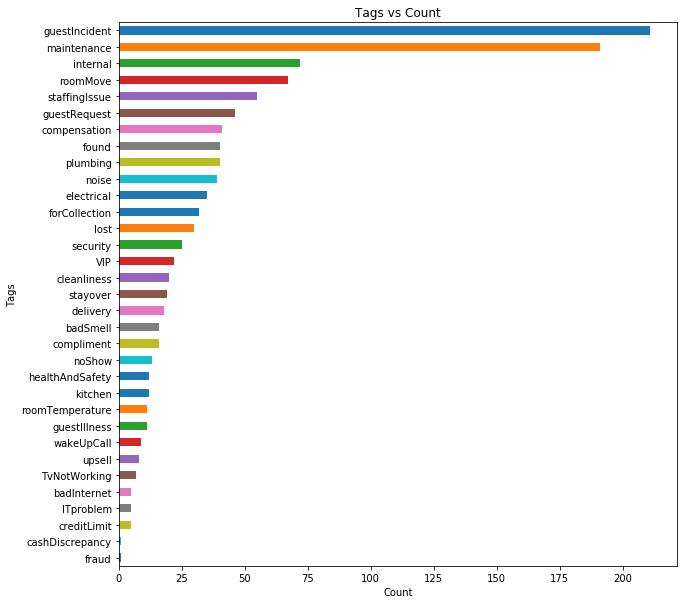

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
count1.plot.barh()
plt.xlabel('Count')
plt.ylabel('Tags')
plt.title(r'Tags vs Count')
plt.gca().invert_yaxis()
plt.savefig('tags.png', dpi=300, bbox_inches='tight')
plt.show()

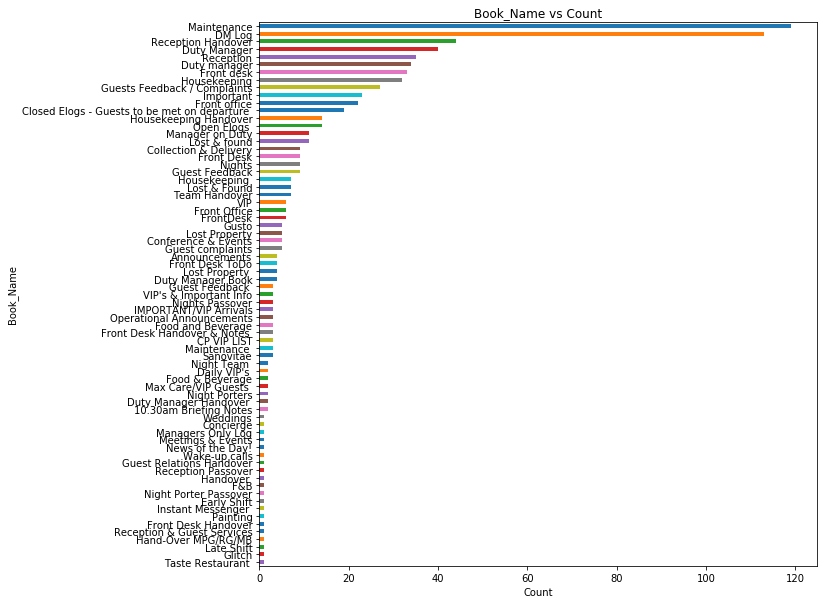

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
count2.plot.barh()
plt.xlabel('Count')
plt.ylabel('Book_Name')
plt.title(r'Book_Name vs Count')
plt.gca().invert_yaxis()
plt.savefig('book_name.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
#text=df.content
#text_list=text.tolist()
#doc_clean = [clean(doc).split() for doc in text_list]

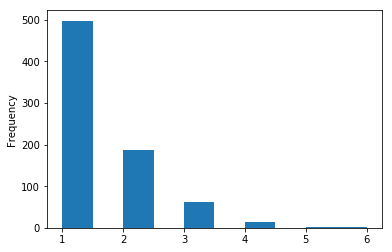

In [13]:
#Histogram

num_elem=[]
for i in ltag:
	num_elem.append(len(i))

s = pd.Series(num_elem)
s.plot(kind = "hist")
plt.savefig('hist_tag.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
#Number of tags 
counter=collections.Counter(num_elem)
counter

Counter({1: 498, 2: 188, 3: 63, 4: 14, 5: 2, 6: 1})

In [15]:
# General Variables and Functions

#English Stop Words
stop = set(stopwords.words('english'))
#Punctuation 
exclude = set(string.punctuation)
# Replace functional approach
repls = ("(", ""), (")", ""), ("'s", "")
#Exclusion Words
words_ex=['room','mr','please','mrs','guest']
#Lemmatization
lemma = WordNetLemmatizer()

#Function to clean text

def clean(text):
    #Remove specific chars
	rem1 = re.sub("[!#*%:1234567890?,.;&-]", "", text)
    #Remove non ASCII chars
	rem2 = re.sub(r'[^\x00-\x7f]', r' ', rem1)
    #Replace using functional approach
	rem3 = reduce(lambda a, kv: a.replace(*kv), repls, rem2)   
    #Exclude stop words
	stop_free = " ".join([i for i in rem2.lower().split() if i not in stop])
    #Exclude Punctuation
	punc_free = ''.join(i for i in stop_free if i not in exclude)
    #Exclude words
	cust_words = " ".join(i for i in punc_free.split() if i not in words_ex)
    #Exclude numbers
	num_free = ''.join([i for i in cust_words if not i.isdigit()])
    #Lemmatization
	normalized = " ".join(lemma.lemmatize(word) for word in num_free.split())
	return normalized

def tokenize(text):
    words = clean(text).split()
    return words

def join_strings(x):
    return " ".join(sorted(x)).strip()

In [16]:
####### Method 1:  Modeling for Multi-Label Classification

# Sklearn Packages 

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Read data

#Selecting only 'content' and 'tags'

#dft=df[['content','tags']]

# 80% Train set and 20% Test set

train, test = train_test_split(df, test_size=0.2)

train_x = train['content'].as_matrix()
test_x = test['content'].as_matrix()
train_y = train['tags'].as_matrix()
test_y = test['tags'].as_matrix()

# Transform train-tags into a multi-label binary format

mlb = MultiLabelBinarizer(classes=list(set(ltag1)))
train_labels = mlb.fit_transform(train_y)

# Transform test-tags into a multi-label binary format

test_labels = mlb.fit_transform(test_y)

# Applying CountVectorizer on character n-grams (specifically for tri-grams range)

count_vectorizer = CountVectorizer(stop_words="english", tokenizer=tokenize, ngram_range=(1, 3),
                                   max_features=10000, analyzer="char")

# Learn and transform train-description

count_vectorizer_train_x = count_vectorizer.fit_transform(train_x)
count_vectorizer_test_x = count_vectorizer.transform(test_x)

# Applying TfIdfVectorizer on individual words(specifically for tri-grams range)

tfidf_vectorizer = TfidfVectorizer(stop_words="english", tokenizer=tokenize, ngram_range=(1, 3),
                                   max_features=10000, analyzer="word")

# Learn and transform train-description

tfidf_vectorizer_train_x = tfidf_vectorizer.fit_transform(train_x)
tfidf_vectorizer_test_x = tfidf_vectorizer.transform(test_x)

# GradientBoostingClassifier with parameter tuning

params = {"n_estimators": 170, "max_depth": 5, "random_state": 10, "min_samples_split": 4, "min_samples_leaf": 2}
classifier = OneVsRestClassifier(GradientBoostingClassifier(**params))

# Generate predictions using counts

classifier.fit(count_vectorizer_train_x, train_labels)
filename1 = 'count_vectorizer_model.pkl'
pickle.dump(classifier, open(filename1, 'wb'))

# Generate predictions using tf-idf representation
classifier.fit(tfidf_vectorizer_train_x, train_labels)
filename2 = 'tfidf_vectorizer_model.pkl'
pickle.dump(classifier, open(filename2, 'wb'))

# Import trained models

count_vectorizer_model, tfidf_vectorizer_model = joblib.load(filename1), joblib.load(filename2)

# Making predictions

pred_1 = count_vectorizer_model.predict(count_vectorizer_test_x.toarray())
pred_2 = tfidf_vectorizer_model.predict(tfidf_vectorizer_test_x.toarray())

pred_3=np.bitwise_or(pred_1,pred_2)

# Combine predictions and map the labels if the values do not equal 0, else assign empty string

comb = np.where((pred_1 + pred_2) != 0, mlb.classes_, "")

# Load the array into a DataFrame constructor and join non-empty strings

predictions = pd.DataFrame(comb).apply(join_strings, axis=1).to_frame("tags")

In [17]:
#New dataframe test 
test1=test.reset_index()
#Comparative dataframe
comp=pd.concat([test1['tags'], predictions['tags']], axis=1, keys=['tags_o', 'tags_p'])


In [80]:
test1.iloc[4,3]

u'624 on service please call the engineering to fix the track of heavy curtain -left hand side small window'

In [18]:
comp

,tags_o,tags_p
0,"[electrical, guestIncident, maintenance]",electrical guestIncident
1,"[guestIncident, noise]",guestIncident noise
2,[staffingIssue],staffingIssue
3,[VIP],TvNotWorking cleanliness compensation guestInc...
4,[maintenance],found maintenance
5,"[maintenance, TvNotWorking]",TvNotWorking
6,[cashDiscrepancy],
7,[guestRequest],
8,[internal],roomMove
9,"[guestIncident, noise]",guestIncident noise


In [19]:
#Performance Metric

#y_true = np.array([[0,1,1],
 #                  [0,1,1],
  #                 [0,1,0],
   #                [0,0,0]])

#y_pred = np.array([[0,1,1],
 #                  [0,1,1],
  #                 [0,1,0],
   #                [0,0,0]])

#Hamming Score
#http://stackoverflow.com/q/32239577/395857

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [20]:
hamming_score(test_labels,pred_3)

0.51751700680272106

In [21]:
sklearn.metrics.accuracy_score(test_labels,pred_3, normalize=True, sample_weight=None)

0.32467532467532467

In [22]:
sklearn.metrics.hamming_loss(test_labels,pred_3)

0.03305785123966942

In [23]:
#Filter by book_name e.g. frontdesk
df.loc[df['book_name'].str.contains("front",case=False),'book_name']='frontdesk'
dfmat=df[df['book_name'].str.contains("front",case=False)]
dfmat

,book_name,bookt_type,content,id,tags,user_id
114,frontdesk,log,@Daniel @Brittney @Wesley Since I am on vacati...,234359,[internal],611
131,frontdesk,log,#318683 Michelle Mullarkey: Its the 8yr old's ...,283711,[guestRequest],757
134,frontdesk,log,Double check the invoices for the weekend,288535,[internal],754
158,frontdesk,log,Complaints- I moved Rm 325 (Colin) to Rm 239 d...,356252,"[guestIncident, noise, roomMove]",793
161,frontdesk,log,@Daniel @Brittney @Kristin_B @Lydia @William F...,367742,[staffingIssue],611
168,frontdesk,log,@Emily Mr.Dean (res #193757) made a reservatio...,389315,[guestRequest],986
174,frontdesk,log,Had to move rm 403 McReynolds to Rm 404 due t...,407729,"[badSmell, guestIncident, roomMove]",793
177,frontdesk,log,wake up call for whole Abbey group for tomorro...,413371,[wakeUpCall],799
187,frontdesk,log,@William @Brittney @Daniel @Lydia - a man w/ l...,430271,[found],733
190,frontdesk,log,#319316 arriving today part of Niamh Ryan grou...,444023,"[guestRequest, VIP]",757


In [24]:
#Unique values for book_name
df.book_name.unique()

array([u'DM Log', u'Nights', u'Maintenance', u'10.30am Briefing Notes',
       u'Reception Handover', u'Concierge', u'Housekeeping Handover',
       u'Gusto', u'Food & Beverage', u'Sanovitae', u'Reception',
       u'Lost & Found', u'Housekeeping', u'Duty Manager', 'frontdesk',
       u'Conference & Events', u'Important', u'Collection & Delivery',
       u'Guests Feedback / Complaints', u'Lost Property',
       u'Nights Passover', u'VIP', u'Taste Restaurant ', u'Announcements',
       u'Night Team ', u'Duty Manager Handover ', u'Guest complaints',
       u'Team Handover', u'Duty manager',
       u'Closed Elogs - Guests to be met on departure ',
       u'Food and Beverage', u'Lost Property ', u'Hand-Over MPG/RG/MB',
       u'Guest Feedback', u'Lost & found', u'Guest Relations Handover',
       u'Open Elogs ', u"Daily VIP's ", u'Maintenance ',
       u'Max Care/VIP Guests ', u'Manager on Duty', u'Housekeeping ',
       u'Instant Messenger ', u'Guest Feedback ', u'Meetings & Events',
     

In [25]:
#Examples
#rt=df.iloc[355,2]
#df.loc[355,:].content
#rt=' Mr Jackson #room 45 lost his wallet in the lobby today morning. The wallet is the brown colour of the brand Diesel. '
#rt='The mirror of the #room 657 is broken, this needs to replace as soon as possible. '
#rt='Mr Johnson #room 367 needs taxi to airport at 3 AM.'
#rt='#room 321 pipe blocked needs to be repaired asap'
#rt='Mr Bond #room 231 needs the newspaper in his room early morning'
#rt='Mrs Clayton #room 490 asked for a continental breakfast at 10 AM'

In [26]:
##### Method 1: Predict a sentence
def pred1(text):
    ex1=pd.Series(text).as_matrix()
    count_vectorizer_ex1 = count_vectorizer.transform(ex1)
    tfidf_vectorizer_ex1 = tfidf_vectorizer.transform(ex1)
    pred1_ex = count_vectorizer_model.predict(count_vectorizer_ex1.toarray())
    pred2_ex = tfidf_vectorizer_model.predict(tfidf_vectorizer_ex1.toarray())
    combex = np.where((pred1_ex + pred2_ex) != 0, mlb.classes_, "")
    predict = pd.DataFrame(combex).apply(join_strings, axis=1).to_frame("tags")
    return predict.iloc[0,0].split()

In [27]:
text=df.iloc[:,2]
text_list=text.tolist()
doc_clean = [tokenize(doc) for doc in text_list]

In [28]:
text.head()

0    Edita from Sanovita called in sick for thie ev...
1                               182 and 629 are VIP's.
2    had to move Mr Pires room 175 to 272 he is wit...
3    Guest in room 539 no wake up call 2 nd time in...
4    !Urgent! - Please replace outside balcony door...
Name: content, dtype: object

In [29]:
doc_clean[4]

[u'urgent',
 u'replace',
 u'outside',
 u'balcony',
 u'door',
 u'handle',
 u'apt',
 u'rm',
 u'stayover',
 u'fitted',
 u'handle']

In [30]:
#Topic Modeling
#import gensim
#from gensim import corpora
#dictionary = corpora.Dictionary(doc_clean)
#doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
#Lda = gensim.models.ldamodel.LdaModel
#ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)
#print(ldamodel.print_topics(num_topics=5, num_words=10))

In [31]:
#ldamodel

In [32]:
#ldamodel.print_topics(num_topics=5, num_words=10)

In [33]:
#ldamodel.print_topics(20)

In [34]:
ltag[0:4]

[[u'staffingIssue'],
 [u'VIP'],
 [u'roomMove'],
 [u'guestIncident', u'wakeUpCall']]

In [35]:
s = pd.Series([ str(ltag[x]).strip('[]') for x in range(len(ltag))])

In [36]:
tg1=df[s.str.contains('noShow',case=False)]
tg1

,book_name,bookt_type,content,id,tags,user_id
77,Reception,log,Mr #Wilde Gary from Carillon turned up today r...,125886,[noShow],408
105,Reception,log,Mr #Campbell is going to be No Show tonight,195137,[noShow],440
169,Duty Manager,log,Mr Murray no show last night,389379,[noShow],736
230,Reception Handover,log,Kostin Dinovski No-Show on 26/09/15 from Tokyo...,579687,[noShow],775
303,Duty Manager,log,Robert Bain and Kayleigh Harripersad no show.,934248,[noShow],1181
438,Housekeeping,log,2 no shows last night room 223 Mark McCarthy /...,1880938,[noShow],1981
530,Housekeeping,log,no shows - 160 and 262,2986404,[noShow],1981
571,Duty Manager,log,SQT Ashtown -No show today -EVENTS LOOKING AFT...,3512406,[noShow],2553
590,Housekeeping,log,321 will be a no show - but will arrive early ...,3734694,[noShow],799
617,Night Porters,log,Room 318 - Toussaint / No Show / C/o,4057203,[noShow],2920


In [37]:
text=tg1.iloc[:,2]
text_list=text.tolist()
doc_clean = [clean(doc).split() for doc in text_list]
l1 = [item for sublist in doc_clean for item in sublist]
pd.Series(l1).value_counts(sort=True,ascending=False)[0:10]

show      14
night      6
last       5
today      4
charge     3
arrive     2
sample     2
co         2
re         2
early      2
dtype: int64

In [38]:
pd.Series(l1).value_counts(sort=True,ascending=False)[0:10].to_dict()

{u'arrive': 2,
 u'charge': 3,
 u'co': 2,
 u'early': 2,
 u'last': 5,
 u'night': 6,
 u're': 2,
 u'sample': 2,
 u'show': 14,
 u'today': 4}

In [39]:
####### Method 2: Heuristic with frequencies

#Functions
def ind(l,pct):
    #l: list of frequencies
    #pct: percentage
    i = 0
    s = 0
    while i < len(l) and s + l[i] < pct:
            s += l[i]
            i += 1
    return i-1


def top_words_tags(df,numw,pct):
    #df: dataframe original format
    #numw: number of words according to the frequency 
    #pct: max percentage
    ltag=df.tags.tolist()
    ltag1 = [item for sublist in ltag for item in sublist]
    s = pd.Series([ str(ltag[x]).strip('[]') for x in range(len(ltag))])
    dict_freq={}
    keys=list(set(ltag1))
    for i in keys:
        tg1=df[s.str.contains(i,case=False)]
        text=tg1.iloc[:,2]
        text_list=text.tolist()
        doc_clean = [clean(doc).split() for doc in text_list]
        l1 = [item for sublist in doc_clean for item in sublist]
        temp1=((pd.Series(l1).value_counts()[0:numw])/sum(pd.Series(l1).value_counts()[0:numw].to_dict().values())*100).to_dict()
        #temp2=sorted(temp1.items(), key=lambda x:x[1],reverse=True)[0:ind(sorted(temp1.values(),reverse=True),pct)]
        #dict_freq[i]=dict((x, y) for x, y in temp2)
        dict_freq[i]=temp1
    return dict_freq


In [40]:
top_words_tags(df,10,80)

{u'ITproblem': {u'back': 12.5,
  u'call': 12.5,
  u'check': 8.333333333333332,
  u'got': 8.333333333333332,
  u'machine': 8.333333333333332,
  u'one': 8.333333333333332,
  u'phone': 8.333333333333332,
  u'service': 8.333333333333332,
  u'till': 8.333333333333332,
  u'working': 16.666666666666664},
 u'TvNotWorking': {u'also': 12.903225806451612,
  u'back': 9.67741935483871,
  u'complained': 12.903225806451612,
  u'falling': 6.451612903225806,
  u'internet': 6.451612903225806,
  u'movie': 9.67741935483871,
  u'ra': 6.451612903225806,
  u'said': 9.67741935483871,
  u'tv': 19.35483870967742,
  u'working': 6.451612903225806},
 u'VIP': {u'arrival': 5.88235294117647,
  u'arriving': 7.352941176470589,
  u'card': 5.88235294117647,
  u'group': 7.352941176470589,
  u'guide': 7.352941176470589,
  u'night': 5.88235294117647,
  u'st': 4.411764705882353,
  u'stay': 10.294117647058822,
  u'today': 5.88235294117647,
  u'vip': 39.705882352941174},
 u'badInternet': {u'also': 8.0,
  u'complained': 8.0,
  

In [41]:
#a='Mr Johnson #room 43 lost his wallet in the lobby and he needs to find it urgently'
#a='Mr Johnson #room 43 lost his wallet in the lobby'
#a=' Mr Jackson #room 45 lost his wallet in the lobby today morning. The wallet is the brown colour of the brand Diesel. '
#a='The mirror of the #room 657 is broken, this needs to replace as soon as possible. '
#a='Mr Johnson #room 367 needs taxi to airport at 3 AM.'
#a='#room 321 pipe blocked needs to be repaired asap'
#a='Mr Bond #room 231 needs the newspaper in his room early morning'
#a='Mrs Clayton #room 490 asked for a continental breakfast at 10 AM'
#lw=list(set(clean(a).split()))


In [42]:
##### Method 2 Prediction 2
train1=train.reset_index().drop('index', axis=1)
def pred2(text,df):
    met={}
    temp1=top_words_tags(df,15,80)
    tags=temp1.keys()
    for i in tags:
        n=0
        for j in tokenize(text):
            if j in temp1[i].keys():
                n+=1
            else:
                n+=0
        met[i]=n
    #p1=dict((x, y) for x, y in sorted(met.items(), key=lambda x:x[1],reverse=True)[0:ind(sorted(met.values(),reverse=True),50)][0:4])
    p1=dict((x, y) for x, y in sorted(met.items(), key=lambda x:x[1],reverse=True)[0:3])
    return p1.keys()    

In [43]:
a=df.iloc[346,2]
a

u'Ensure to place a trace if an item needs to be collected from a room upon departure, like Gin & Tonic set-up, card playing table & etc.'

In [44]:
#Real Tags
df.iloc[346,4]

[u'internal']

In [45]:
#Method 1
pred1(a)

[u'internal']

In [46]:
#Method 2
pred2(a,train1)

[u'stayover', u'internal', u'guestRequest']

In [47]:
test2=test.reset_index().drop('index', axis=1)

In [48]:
test2['content'].shape[0]

154

In [49]:
test2=test.reset_index().drop('index', axis=1)
def testmet(df):
    lx=list(df['content'])
    nl=len(lx)
    lp=[]
    for i in lx:
        lp.append(pred2(i,train1))
    return lp

In [50]:
testmet(test2)

[[u'cleanliness', u'roomTemperature', u'electrical'],
 [u'roomTemperature', u'noise', u'TvNotWorking'],
 [u'noShow', u'roomTemperature', u'staffingIssue'],
 [u'cleanliness', u'stayover', u'compensation'],
 [u'found', u'lost', u'guestIncident'],
 [u'TvNotWorking', u'internal', u'maintenance'],
 [u'delivery', u'forCollection', u'guestIncident'],
 [u'noShow', u'internal', u'guestIncident'],
 [u'badInternet', u'TvNotWorking', u'maintenance'],
 [u'noShow', u'noise', u'roomMove'],
 [u'noShow', u'ITproblem', u'staffingIssue'],
 [u'stayover', u'fraud', u'guestRequest'],
 [u'upsell', u'kitchen', u'guestRequest'],
 [u'delivery', u'internal', u'kitchen'],
 [u'plumbing', u'noShow', u'maintenance'],
 [u'noShow', u'compensation', u'guestIncident'],
 [u'roomTemperature', u'noise', u'roomMove'],
 [u'cleanliness', u'compensation', u'guestIncident'],
 [u'wakeUpCall', u'guestRequest', u'guestIncident'],
 [u'internal', u'ITproblem', u'guestIncident'],
 [u'fraud', u'ITproblem', u'guestIncident'],
 [u'wakeU

In [51]:
predictions2=pd.Series(testmet(test2))
comp1=pd.concat([test1['tags'], predictions2], axis=1, keys=['tags_o', 'tags_p'])

In [52]:
comp1

,tags_o,tags_p
0,"[electrical, guestIncident, maintenance]","[cleanliness, roomTemperature, electrical]"
1,"[guestIncident, noise]","[roomTemperature, noise, TvNotWorking]"
2,[staffingIssue],"[noShow, roomTemperature, staffingIssue]"
3,[VIP],"[cleanliness, stayover, compensation]"
4,[maintenance],"[found, lost, guestIncident]"
5,"[maintenance, TvNotWorking]","[TvNotWorking, internal, maintenance]"
6,[cashDiscrepancy],"[delivery, forCollection, guestIncident]"
7,[guestRequest],"[noShow, internal, guestIncident]"
8,[internal],"[badInternet, TvNotWorking, maintenance]"
9,"[guestIncident, noise]","[noShow, noise, roomMove]"


In [53]:
test2.iloc[126,2]

u'#704 Mr.Lemelbaum came to reception to report that he had a white envelope with money left on the table that was missing from the room. DM and security searched the room and found it in the guests suitcase'

In [54]:
#Matrix prediction 2
m_y = comp1['tags_p'].as_matrix()
mlb = MultiLabelBinarizer(classes=list(set(ltag1)))
pred_4 = mlb.fit_transform(m_y)

In [55]:
hamming_score(test_labels,pred_4)

0.2556895485466914

In [56]:
sklearn.metrics.accuracy_score(test_labels,pred_4, normalize=True, sample_weight=None)

0.012987012987012988

In [57]:
sklearn.metrics.hamming_loss(test_labels,pred_4)

0.08579299488390398

In [58]:
#Method 3 Frequency + Sentence Similarity
#Semantic Similarity

def penn_to_wn(tag):
    #""" Convert between a Penn Treebank tag to a simplified Wordnet tag """
    if tag.startswith('N'):
        return 'n'
 
    if tag.startswith('V'):
        return 'v'
 
    if tag.startswith('J'):
        return 'a'
 
    if tag.startswith('R'):
        return 'r'
 
    return None
 
def tagged_to_synset(word, tag):
    wn_tag = penn_to_wn(tag)
    if wn_tag is None:
        return None
 
    try:
        return wn.synsets(word, wn_tag)[0]
    except:
        return None

#This algorithm is proposed by Mihalcea et al. in the paper “Corpus-based and Knowledge-based Measures
#of Text Semantic Similarity” (https://www.aaai.org/Papers/AAAI/2006/AAAI06-123.pdf)

def sentence_similarity(sentence1, sentence2):
    # compute the sentence similarity using Wordnet
    # Tokenize and tag
    sentence1 = pos_tag(word_tokenize(sentence1))
    sentence2 = pos_tag(word_tokenize(sentence2))
 
    # Get the synsets for the tagged words
    synsets1 = [tagged_to_synset(*tagged_word) for tagged_word in sentence1]
    synsets2 = [tagged_to_synset(*tagged_word) for tagged_word in sentence2]
 
    # Filter out the Nones
    synsets1 = [ss for ss in synsets1 if ss]
    synsets2 = [ss for ss in synsets2 if ss]
 
    score, count = 0.0, 0
 
    # For each word in the first sentence
    for synset in synsets1:
        # Get the similarity value of the most similar word in the other sentence
        best_score = max([synset.path_similarity(ss) for ss in synsets2])
 
        # Check that the similarity could have been computed
        if best_score is not None:
            score += best_score
            count += 1
 
    # Average the values
    if count!=0:
        score /= count
    else:
        score=0
    return score

In [59]:
sentence_similarity('black dog','big dog ')

1.0

In [60]:
a=clean(df.iloc[646,2])
a

u'honigstock emailed executive office complain several issue stay happy arrived hotel ready checked mentioned bathroom flooded due shower requesting compensation night stay vip forwarded mohkg ec meet honigstock separate glitch placed feedback new room'

In [61]:
b=clean('Mr Johnson complained his room was dirty and messy. He claims for a compensation')
b

u'johnson complained dirty messy claim compensation'

In [62]:
sentence_similarity(a,b)

0.2269726305440591

In [63]:
c=clean('Mr Johnson #room 45 ask for an Irish breakfast tomorrow morning at 6 AM')
c

'johnson ask irish breakfast tomorrow morning'

In [64]:
sentence_similarity(a,c)

0.16619821976964835

In [65]:
d=clean('Mr Johnson #room 45 called because the shower is broken and the bathroom floor is flooded and asks for a compensation. He is a VIP')
d

'johnson called shower broken bathroom floor flooded asks compensation vip'

In [66]:
sentence_similarity(a,d)

0.30371969300540724

In [67]:
##### Method 3 Prediction 3
train1=train.reset_index().drop('index', axis=1)
def pred3(text,df):
    meta={}
    temp1=top_words_tags(df,15,80)
    tags=temp1.keys()
    for i in tags:
        str1=" ".join(temp1[i].keys())
        meta[i]=sentence_similarity(clean(text),str1)
    p1=dict((x, y) for x, y in sorted(meta.items(), key=lambda x:x[1],reverse=True)[0:3])
    return p1.keys()
        

In [68]:
a=df.iloc[368,2]
a

u'#707 Ms. Battista checked in at around 02:00 am and the guest told to the porter she was not happy with room allocated 707 as pantry door is close by and as per her previous experience is very noisy. The guest told she would like to move to another Suite tomorrow morning.  However we have had no other Suites available. It was too late to call the guest to agree on a next step as she informed the porter she wants to be called tomorrow morning only. Early Reception shift to follow up.'

In [69]:
#Real Tags
df.iloc[368,4]

[u'guestIncident', u'noise', u'roomMove']

In [70]:
#Method 1
pred1(a)

[u'guestIncident', u'noise', u'roomMove']

In [71]:
#Method 2
pred2(a,train1)

[u'noise', u'staffingIssue', u'guestRequest']

In [72]:
#Method 3
pred3(a,train1)

[u'guestRequest', u'staffingIssue', u'guestIncident']

In [73]:
def testmet1(df):
    lx=list(df['content'])
    nl=len(lx)
    lp=[]
    for i in lx:
        lp.append(pred3(i,train1))
    return lp

In [74]:
testmet1(test2)
predictions3=pd.Series(testmet1(test2))
comp2=pd.concat([test1['tags'], predictions2], axis=1, keys=['tags_o', 'tags_p'])
comp2

,tags_o,tags_p
0,"[electrical, guestIncident, maintenance]","[cleanliness, roomTemperature, electrical]"
1,"[guestIncident, noise]","[roomTemperature, noise, TvNotWorking]"
2,[staffingIssue],"[noShow, roomTemperature, staffingIssue]"
3,[VIP],"[cleanliness, stayover, compensation]"
4,[maintenance],"[found, lost, guestIncident]"
5,"[maintenance, TvNotWorking]","[TvNotWorking, internal, maintenance]"
6,[cashDiscrepancy],"[delivery, forCollection, guestIncident]"
7,[guestRequest],"[noShow, internal, guestIncident]"
8,[internal],"[badInternet, TvNotWorking, maintenance]"
9,"[guestIncident, noise]","[noShow, noise, roomMove]"


In [75]:
#Matrix prediction 2
m_y = comp2['tags_p'].as_matrix()
mlb = MultiLabelBinarizer(classes=list(set(ltag1)))
pred_5 = mlb.fit_transform(m_y)
hamming_score(test_labels,pred_5)

0.2556895485466914

In [76]:
sklearn.metrics.accuracy_score(test_labels,pred_5, normalize=True, sample_weight=None)

0.012987012987012988

In [77]:
sklearn.metrics.hamming_loss(test_labels,pred_5)

0.08579299488390398

In [90]:
pred3('wallet was left on the table in the room 45',train1)

[u'forCollection', u'found', u'cleanliness']

In [93]:
pred3('Music volume in the lobby cannot be controlled. It only goes up. Paul will call company that look after our system to fix it.',train1)

[u'healthAndSafety', u'lost', u'guestIncident']